In [39]:
import torch
from matplotlib import pyplot as plot
from torch.nn import functional as F

In [40]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5], len(names)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [41]:
chars = list(set("".join(names)))
chars.insert(0, ".")
chars

['.',
 'z',
 'l',
 'j',
 'v',
 'r',
 'b',
 'w',
 'c',
 'p',
 'f',
 'a',
 'h',
 'm',
 'o',
 't',
 'i',
 'q',
 's',
 'g',
 'e',
 'n',
 'd',
 'k',
 'x',
 'y',
 'u']

In [42]:
ctoi = { c:i for i, c in enumerate(chars)}
itoc = { i:c for i, c in enumerate(chars)}

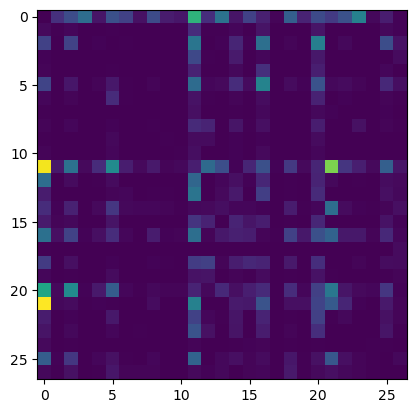

In [43]:
N = torch.zeros((27, 27), dtype=torch.int) # N is count vector

for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        c1i = ctoi[c1]
        c2i = ctoi[c2]
        N[c1i, c2i] += 1
        
plot.imshow(N)

In [44]:
P = N / N.sum(dim=1, keepdims=True)
P[5,:].sum()

tensor(1.)

In [46]:
bigrams = []
for x in names:
    x = "." + x + "."
    for c1, c2 in zip(x, x[1:]):
        bigrams.append((c1, c2))

In [47]:
nll = 0;

for c1, c2 in bigrams:
    c1 = ctoi[c1]
    c2 = ctoi[c2]
    nll += P[c1, c2].log().item()

nll = -nll / len(bigrams)
nll

2.454014497322693

In [48]:
gen = torch.Generator()
gen.manual_seed(2147483647)

for _ in range(10):
    name = "."
    while(True):
        c1 = name[-1]
        c1i = ctoi[c1]
        p = P[c1i]
        c2i = torch.multinomial(p, 1, generator=gen).item()
        c2 = itoc[c2i]
        name += c2

        if c2 == ".":
            break
    
    print(name)

.jexllahaniansaniriaeycari.
.fameeen.
.kshanna.
.a.
.an.
.ale.
.jein.
.felas.
.pheli.
.maunaranda.


## Bigram Neural Net

In [70]:
def create_dataset(names): 
    x = []
    y = []
    for s in names:
        s = "." + s + "."
        for c1, c2 in zip(s, s[1:]):
            x.append(ctoi[c1])
            y.append(ctoi[c2])
    
    x = F.one_hot(torch.tensor(x), num_classes=27).float()
    y = torch.tensor(y)
    
    return x, y
    
x, y = create_dataset(names)
x.shape

torch.Size([228146, 27])

In [110]:
train, dev, test = torch.utils.data.random_split(names, [0.8, 0.10, 0.1])
len(train), len(dev), len(test)

(25627, 3203, 3203)

In [111]:
train_ds = create_dataset(train)
dev_ds = create_dataset(dev)
test_ds = create_dataset(test)

In [121]:
def fits(W, dataset, epoch):
    X, ys = dataset
    n = X.shape[0]
    
    for i in range(epoch):
        W.grad = None
        
        logits = X @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(n), ys].log().mean()
        loss.backward()

        if i % 10 == 0:
            print(loss.item())

        W.data -= 10 * W.grad

W = torch.randn(27, 27, requires_grad=True)
fits(W, train_ds, 10)

3.8094301223754883


In [122]:
def cal_loss(W, ds):
    with torch.no_grad():
        X, ys = ds
        n = X.shape[0]
        logits = X @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss = -probs[torch.arange(n), ys].log().mean().item()
    
    return loss

W = torch.randn(27, 27, requires_grad=True)
cal_loss(W, train_ds)

3.627561330795288

In [123]:
W = torch.randn(27, 27, requires_grad=True)

dev_loss = cal_loss(W, dev_ds)
print(f"dev loss: {dev_loss}")
print("==========")

fits(W, train_ds, 100)

print("==========")
print(f"dev loss: {cal_loss(W, dev_ds)}")

dev loss: 3.7033116817474365
3.6955363750457764
3.1389970779418945
2.9038889408111572
2.7826695442199707
2.7097244262695312
2.662559986114502
2.6301164627075195
2.6064727306365967
2.588435649871826
2.574188232421875
dev loss: 2.5668811798095703


In [124]:
def sample(W):
    res = "."
    while(True):
        c = res[-1]
        x = torch.tensor(ctoi[c])
        x = F.one_hot(x, num_classes=27).reshape(1, 27).float()

        logits = x @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        ix = torch.multinomial(probs, 1, generator=gen).item()
        c2 = itoc[ix]

        res += c2
        if c2 == ".":
            break;

    return res

for _ in range(10):
    print(sample(W))

.kem.
.nuqgemeca.
.ma.
.km.
.a.
.egkjxbradhjahck.
.biya.
.ah.
.a.
.lahalanana.
